In [2]:
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random

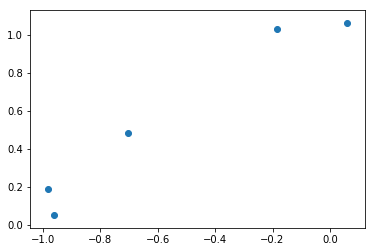

In [3]:
#function data is generated from
def f(x):
    return x**3 + 0.1*x + 1 + np.random.normal(scale = 0.1)

num_datapoints = 5
r_size = 2
z_size = 2

datapoints = []
for i in range(num_datapoints):
    x = np.random.uniform(-1,1)
    datapoints.append([x,f(x)])
datapoints = np.array(datapoints)
    
plt.scatter(datapoints[:,0], datapoints[:,1])

In [4]:
class r_encoder(nn.Module):
    def __init__(self):
        super(r_encoder, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, r_size)
        self.relu = nn.ReLU()
        
    def forward(self, z):
        r1 = self.relu(self.fc1(z))
        r2 = self.relu(self.fc2(r1))
        output = self.fc3(r2)
        return output

class z_encoder(nn.Module):
    def __init__(self):
        super(z_encoder, self).__init__()
        self.fc1 = nn.Linear(r_size, 10)
        self.fc2_mu = nn.Linear(10, z_size)
        self.fc2_logvar = nn.Linear(10, z_size)
        self.relu = nn.ReLU()
        
    def forward(self, r):
        r1 = self.relu(self.fc1(r))
        mu = self.fc2_mu(r1)
        logvar = self.fc2_logvar(r1)
        return mu, logvar
    
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(z_size + 1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        
    def forward(self, z, x):
        zx = torch.cat((z,x))
        r1 = self.relu(self.fc1(zx))
        r2 = self.relu(self.fc2(r1))
        output = self.fc3(r2)
        return output

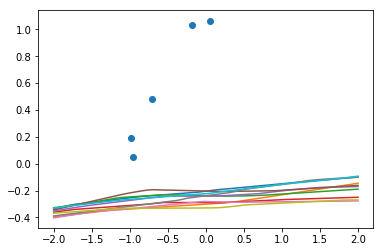

In [5]:
EncR = r_encoder()
EncZ = z_encoder()
Dec = decoder()

R_Opt = torch.optim.Adam(EncR.parameters(), lr=1e-3)
Z_Opt = torch.optim.Adam(EncZ.parameters(), lr=1e-3)
D_Opt = torch.optim.Adam(Dec.parameters(), lr=1e-3)

def log_likelihood(mu, std, target):
    norm = torch.distributions.Normal(mu, std)
    return norm.log_prob(target).sum(dim=0).mean()

def KL_div(mu1, mu2, std1, std2, z):
    a = log_likelihood(mu1, std1, z)
    b = log_likelihood(mu2, std2, z)
    return a - b

def MSE(ypred, yactual):
    return (ypred - yactual)**2

def get_z(mu, logvar):
    std = torch.exp(0.5*logvar)
    N = torch.randn_like(10*std)
    return mu + N*std

#plots before training:
def plot():
    num_plots = 10
    lin = np.linspace(-2, 2, 500)
    for i in range(num_plots):
        R = EncR(torch.tensor(datapoints).float())
        Rmean = torch.sum(R, dim=0)/len(R)
        mu, logvar = EncZ(Rmean)
        Z = get_z(mu, logvar)
        results = []
        for j in range(len(lin)):
            Lj = torch.tensor([lin[j]])
            result = Dec(Z, Lj).detach().numpy()
            results.append(result)
        results = np.array(results)
        plt.plot(lin, results)
    plt.scatter(datapoints[:,0], datapoints[:,1])    
    plt.show()
    
plot()

In [6]:
def forward(data, point):
    R = EncR(data)
    Rmean = torch.sum(R,dim=0)
    mu, logvar = EncZ(Rmean)
    Z = get_z(mu, logvar)
    ypred = Dec(Z, point)
    return ypred, mu, logvar, Z

def loss(y, ypred, mu, std, z):
    return MSE(ypred, y) + KL_div(mu, torch.tensor([0.,0.]), std, torch.tensor([1.,1.]), z)

epochs = 1000
def train(data):
    data = torch.tensor(data).float()
    for epoch in range(epochs):
        epoch_loss = 0
        for point in data:
            R_Opt.zero_grad()
            Z_Opt.zero_grad()
            D_Opt.zero_grad()
            y = point[1]
            x = point[0]
            x = torch.tensor([x], requires_grad=True).float()
            ypred, mu, logvar, z = forward(data, x)
            std = (1/2*logvar).exp_()
            los = loss(y, ypred, mu, std, z)
            los.backward(retain_graph=True)
            epoch_loss += los
            R_Opt.step()
            Z_Opt.step()
            D_Opt.step()
        
        if epoch % 100 == 0:
            print('EPOCH: {}, EPOCH LOSS: {}'.format(epoch, epoch_loss[0]))
            plot()

EPOCH: 0, EPOCH LOSS: 3.6738641262054443


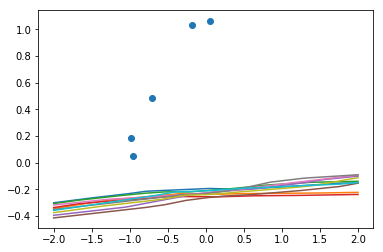

EPOCH: 100, EPOCH LOSS: 0.39225873351097107


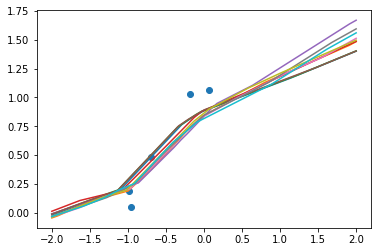

EPOCH: 200, EPOCH LOSS: 0.09563776850700378


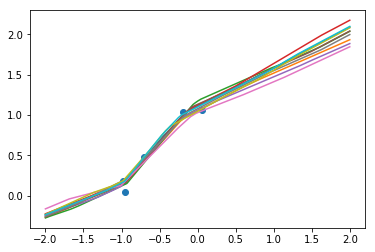

EPOCH: 300, EPOCH LOSS: 0.2062152922153473


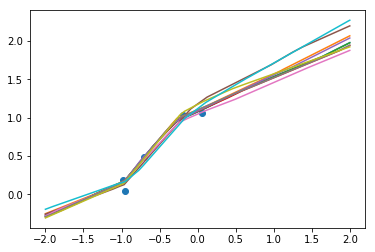

EPOCH: 400, EPOCH LOSS: 0.1293981671333313


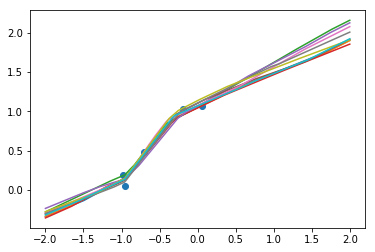

EPOCH: 500, EPOCH LOSS: 0.33080345392227173


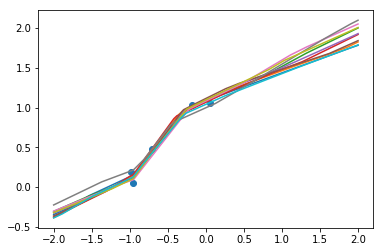

EPOCH: 600, EPOCH LOSS: -0.009891128167510033


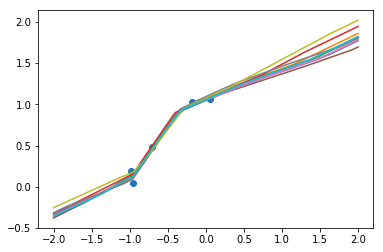

EPOCH: 700, EPOCH LOSS: 0.03698742389678955


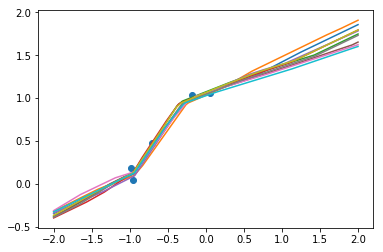

EPOCH: 800, EPOCH LOSS: 0.41515129804611206


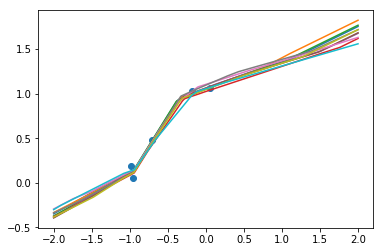

EPOCH: 900, EPOCH LOSS: 0.03644077479839325


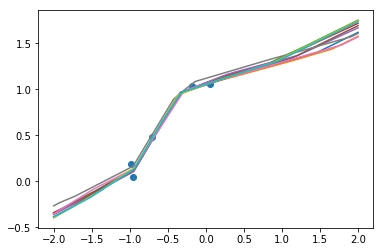

In [7]:
train(datapoints)